# Pix2Pix

You will work in teams to prepare videos and select ONE task from a list to be shared with everyone in the class.

TASKS:

1. Prepare a handful of short videos
1. Make a .pict model to use in tf.js
1. ...




This notebook demonstrates image to image translation using conditional GAN's, as described in [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004). Using this technique we can colorize black and white photos, convert google maps to google earth, etc. Here, we convert building facades to real buildings.

In example, we will use the [CMP Facade Database](http://cmp.felk.cvut.cz/~tylecr1/facade/), helpfully provided by the [Center for Machine Perception](http://cmp.felk.cvut.cz/) at the [Czech Technical University in Prague](https://www.cvut.cz/). To keep our example short, we will use a preprocessed [copy](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/) of this dataset, created by the authors of the [paper](https://arxiv.org/abs/1611.07004) above.

Each epoch takes around 58 seconds on a single P100 GPU.

Below is the output generated after training the model for 100 epochs on my daughter's hand in front of a white counter. The light is more directional than I wanted. 

![](https://www.evernote.com/shard/s51/sh/1e899837-cbdc-4867-be28-863b21fe0f21/xNCTgzSZBHNzz1a3Z7vhsLMl3FJ1Wn4LsfmmQRJCUFnQhvGmZumErrTtrQ/deep/0/image.png)



# Prepare your images

You want a folder full of images named from 1.jpg to 500.jpg that look like this:

![](https://www.evernote.com/shard/s51/sh/ac3fe423-9a5c-4db6-a1ff-4ec88fcc3a05/PVgCmi4KEVY2duPINsRVxU_ymNq1j8bb8qJzmMr9d4LL8MGBh6Zb6ENR1w/deep/0/image.png)

1. shoot a short movie against a white backdrop
1. bring the movie into an editor (I used Premiere). Make adjustments if necessary.
1. output a sequence of square images of 1080x1080 px
1. Open Photoshop and use my preparepix2pix script to make a folder of prepared AB images.
1. Split folders like this: `splitfolders --output handEdgesGo --ratio .8 .1 .1 -- handEdges`
1. clean things up and zip the 

```
 % splitfolders --output handEdgesGo --ratio .8 .1 .1 -- handEdges
 % mv test/JPEG/* test                   
 % cd handEdgesGo
handEdgesGo % mv val/JPEG/* val                      
handEdgesGo % mv train/JPEG/* train                  
handEdgesGo % mv test/JPEG/* test                   
handEdgesGo % rmdir test/JPEG train/JPEG val/JPEG 
handEdgesGo % cd .. 
handEdgesGo % zip handEdgesGo
```


1. Zip the file and upload it to the /content folder on Google Colab
1. unzip with the command below
1. move the folder into `datasets/`

Here, we take the below videos and extract images from them.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! rm -Rf /content/__MACOSX ;  # get rid of the OSX trash
! rm -Rf /content/output ;    # get rid of old images

! apt install unzip ;
! unzip '/content/drive/MyDrive/Senior/MS 038/pix2pix data/pix2pix-dataset.zip' >> /dev/null ;

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


In [ ]:
# !rm -Rf /content/datasets/handEdgesGo ;   # reset
# !rm -Rf /content/__MACOSX ;  # get rid of the OSX trash

# !apt install unzip ;         # if you need to install the "unzip" function
# ! unzip handEdgesGo.zip        # unzip the archive of pics

In [ ]:
# ! cp handEdgesGo.zip /content/drive/MyDrive/AI/.   # save a copy of the archive

## Import TensorFlow and other libraries

In [ ]:
import os
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output

!nvidia-smi

Wed Feb 22 22:23:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# How many Epochs? 200 is nice, but...
EPOCHS = 100

In [ ]:
# ! tar -cvzf /content/checkpoints.tgz /content/training_checkpoints ;
# ! rm -Rf /content/training_checkpoints ;

## Load the dataset

You can download this dataset and similar datasets from [here](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/). As mentioned in the [paper](https://arxiv.org/abs/1611.07004) we apply random jittering and mirroring to the training dataset.


* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [ ]:
_URL = 'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/'

# maps.tar.gz
# facades.tar.gz
pickone = "facades" # "handEdgesGo" # facades (29M), or maps (239M), or cityscapes (99M), or edges2shoes (2G), or edges2handbags (8G) 
# zname = pickone + ".tar.gz"
zname = pickone + ".zip"

path_to_zip = tf.keras.utils.get_file(fname=zname,
                                      cache_dir="./",
                                      origin=_URL, 
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), pickone+'/')
print(PATH)

2042/2042 [==============================] - 0s 0us/step
./datasets/handEdgesGo/


In [ ]:
# !unzip /content/handEdgesGo.zip ;             # in case you didn't unzip it yet
# ! mv /content/handEdgesGo /content/datasets/ ;  # put the images where you need them

In [ ]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3

In [ ]:
def load(image_file):
    
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    
    w = tf.shape(image)[1]
    w = w // 2
    # real_image = image[:, :w, :]
    # input_image = image[:, w:, :]
    input_image = image[:, :w, :]
    real_image = image[:, w:, :]
    
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
    
    return input_image, real_image

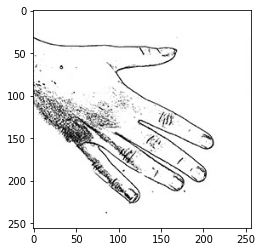

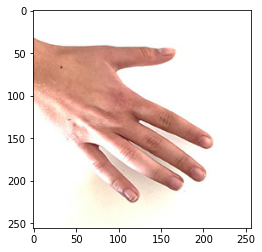

In [ ]:
inp, re = load(PATH+'train/1.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [ ]:
def resize(input_image, real_image, height, width):
    
    input_image = tf.image.resize(input_image, [height, width], 
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width], 
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
    
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop( stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    
    return cropped_image[0], cropped_image[1]

In [ ]:
# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    
    input_image = (input_image / 127.5) - 1
    real_image  = (real_image   / 127.5) - 1
    
    return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)
    
    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    
    return input_image, real_image

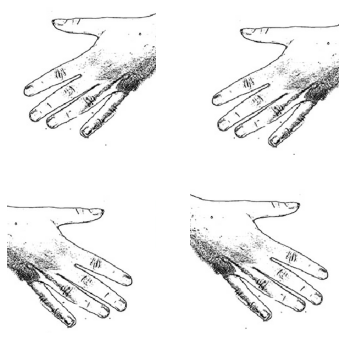

In [ ]:
# As you can see in the images below
# that they are going through random jittering
# Random jittering as described in the paper is to
# 1. Resize an image to bigger height and width
# 2. Randomnly crop to the original size
# 3. Randomnly flip the image horizontally 

plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)  
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
plt.show()

In [ ]:
def load_image_train(image_file):
    
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

In [ ]:
def load_image_test(image_file):
    
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,  IMG_HEIGHT, IMG_WIDTH) 
    input_image, real_image = normalize(input_image, real_image)
    
    return input_image, real_image

## Input Pipeline

In [ ]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

In [ ]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).
 
    

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
    
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add( tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
    
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.ReLU())
    return result

In [ ]:
def Generator():
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, 
                                         strides=2, 
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)
    concat = tf.keras.layers.Concatenate() 
    
    inputs = tf.keras.layers.Input(shape=[None,None,3])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

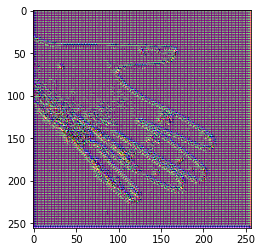

In [ ]:
generator = Generator()
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake. 
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [ ]:
def Discriminator():
    
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)
    
    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, 
                                kernel_initializer=initializer, 
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv) 
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

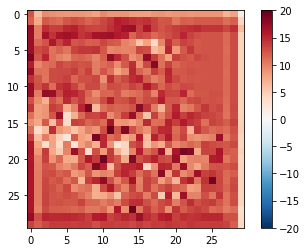

In [ ]:
discriminator = Discriminator()
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

## Define the loss functions and the optimizer

* **Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss
  
* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
    LAMBDA = 100
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss

In [ ]:
generator_optimizer      = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoints (Object-based saving)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training

* We start by iterating over the dataset
* The generator gets the input image and we get a generated output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, we calculate the generator and the discriminator loss.
* Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.


## Generate Images

* After training, its time to generate some images!
* We pass images from the test dataset to the generator.
* The generator will then translate the input image into the output we expect.
* Last step is to plot the predictions and **voila!**

In [ ]:
def generate_images(model, test_input, tar):
    # the training=True is intentional here since
    # we want the batch statistics while running the model
    # on the test dataset. If we use training=False, we will get 
    # the accumulated statistics learned from the training dataset
    # (which we don't want)
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [ ]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    
    generator_gradients = gen_tape.gradient(gen_loss, 
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, 
                                          discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, 
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, 
                                              discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):  
    
    for epoch in range(epochs):
        start = time.time()
        
        for input_image, target in dataset:
            train_step(input_image, target)
        
        clear_output(wait=True)
        for inp, tar in test_dataset.take(1):
            generate_images(generator, inp, tar)
        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0: checkpoint.save(file_prefix = checkpoint_prefix)
        
        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

# Training starts HERE 

Redefine EPOCHS if you want. Each Epoch takes about 36 seconds on a Tesla T4. 

200 is primo.

In [ ]:
print(f"Run {EPOCHS} EPOCHS")

Run 100 EPOCHS


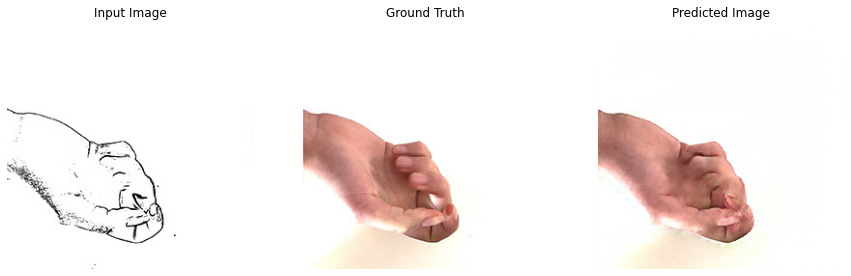

Time taken for epoch 100 is 35.34091114997864 sec



In [ ]:
train(train_dataset, EPOCHS)

## Restore the latest checkpoint to test

In [ ]:
!ls {checkpoint_dir}

checkpoint		    ckpt-3.index
ckpt-1.data-00000-of-00001  ckpt-4.data-00000-of-00001
ckpt-1.index		    ckpt-4.index
ckpt-2.data-00000-of-00001  ckpt-5.data-00000-of-00001
ckpt-2.index		    ckpt-5.index
ckpt-3.data-00000-of-00001


In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Testing on the entire test dataset

20 Epochs produces this:
![](https://www.evernote.com/shard/s51/sh/4e143215-77b3-4c77-b986-ea44e01a7f39/eMO6BAM0iHZvSYtmmRqdgsaHkOqz9f7MLHS3eM3vlWRbRdfKlcXWA0nOLA/deep/0/image.png)

# Save a copy of the checkpoints

you can turn these into the .pict file used by tf.js (like edges2cats)

# Who wants to make a ".pict" model for a web interface like edges2cats? 

See this: 
https://github.com/affinelayer/pix2pix-tensorflow/tree/master/server

In [ ]:
! cp -R ./training_checkpoints /content/drive/MyDrive/AI/ ;   # keep a copy of the training checkpoints

In [ ]:
! rm -Rf /content/pix2pix-tensorflow-master ;
!wget "https://github.com/CaiNowicki/pix2pix-tensorflow/archive/refs/heads/runs-under-tensorflow2.zip" ;
!unzip master.zip

In [ ]:
# # Create the PICT model file

# FAIL!

# ! python /content/pix2pix-tensorflow-master/server/tools/export-checkpoint.py \
#   --checkpoint /content/drive/MyDrive/AI/training_checkpoints \
#   --output_file /content/drive/MyDrive/AI/handEdgesGo.pict

SCRIPT_DIR is /content/pix2pix-tensorflow-master/server/tools
2023-02-22 22:53:22.414885: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-22 22:53:22.415046: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-22 22:53:22.415076: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Writing variable generator_optimizer/_variables/9/.ATTRIBUTES/VARIABLE_VALUE...
Writing variable generato

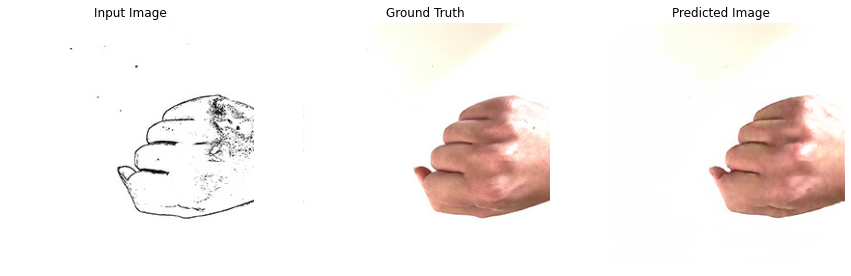

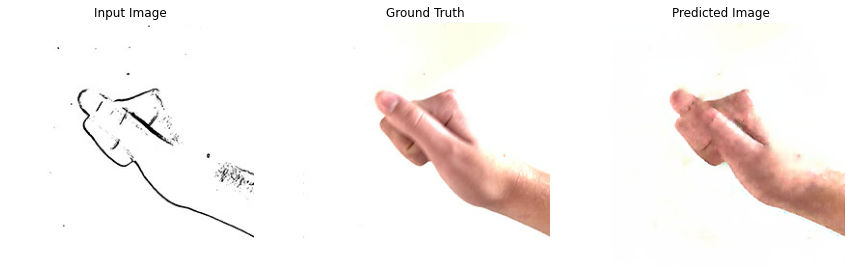

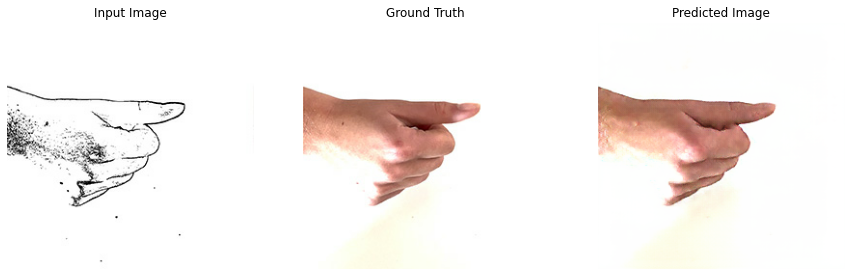

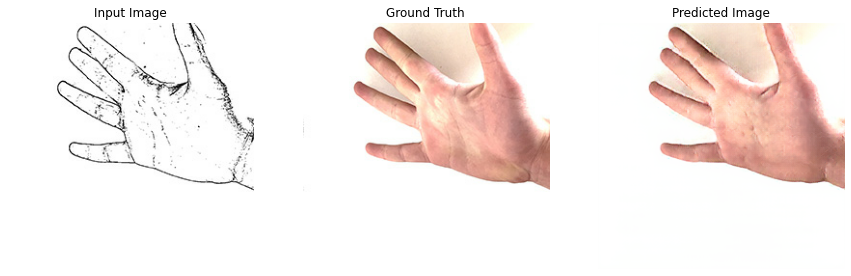

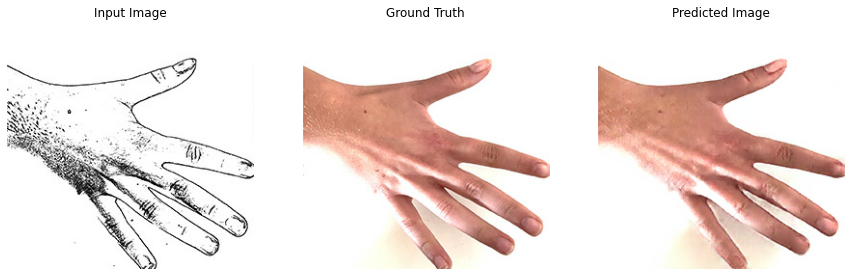

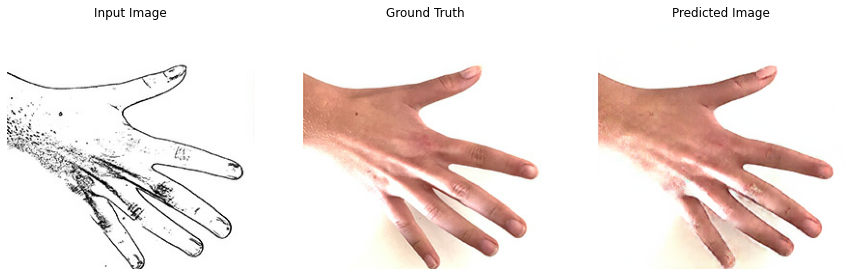

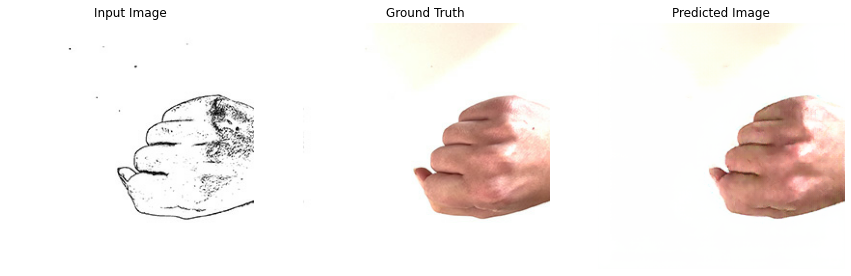

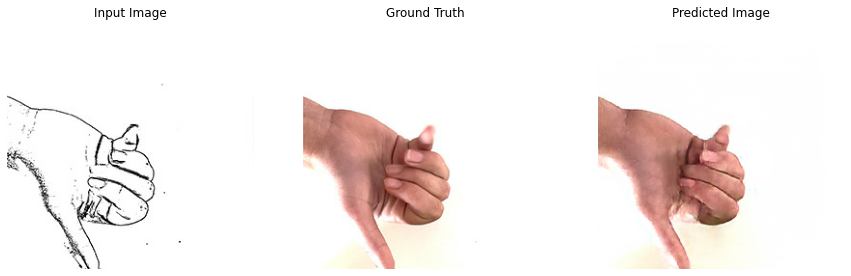

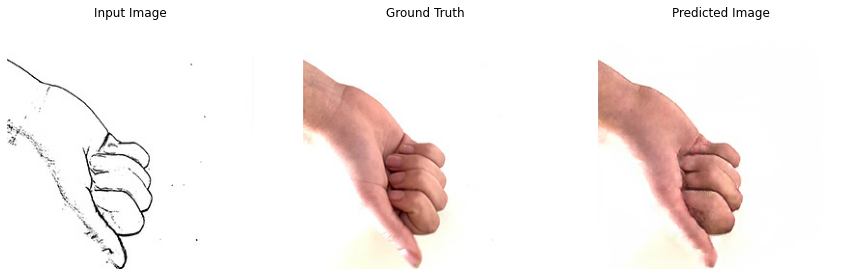

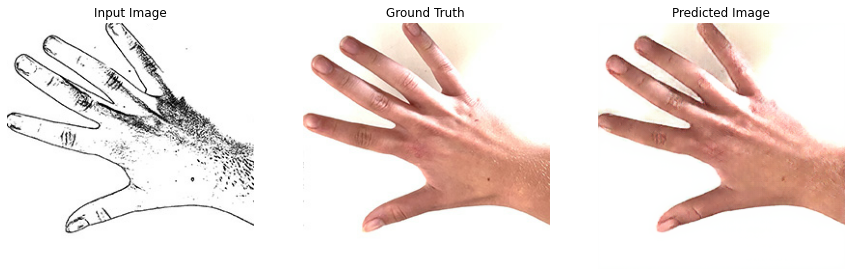

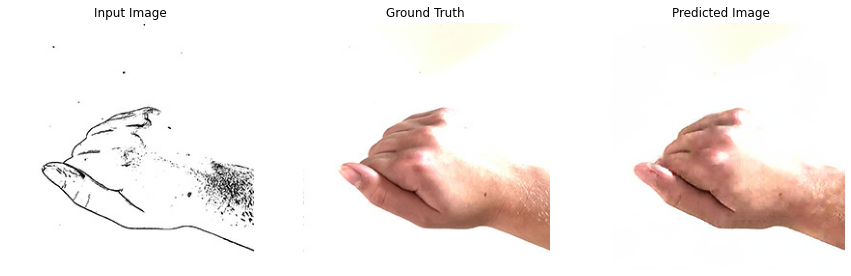

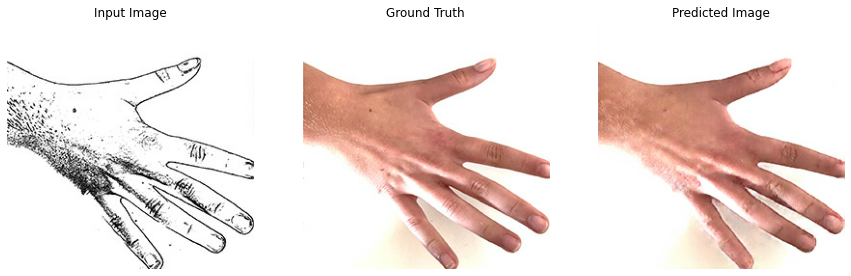

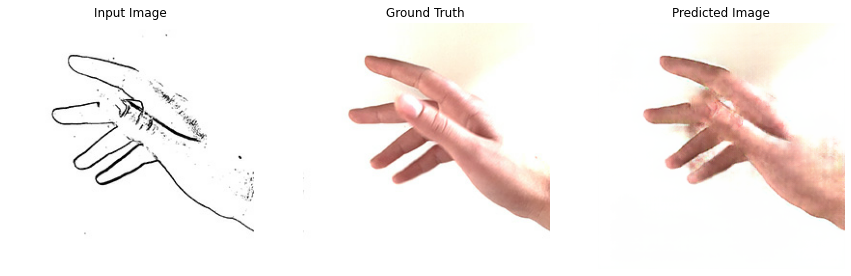

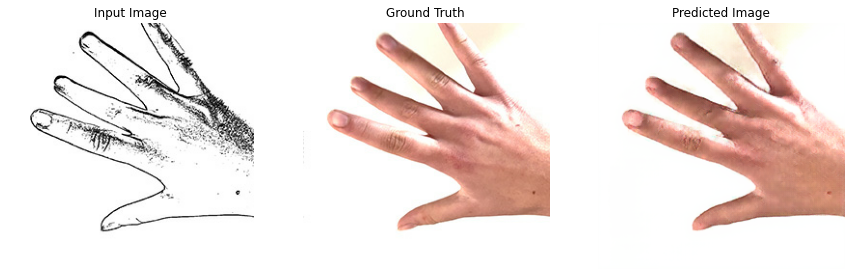

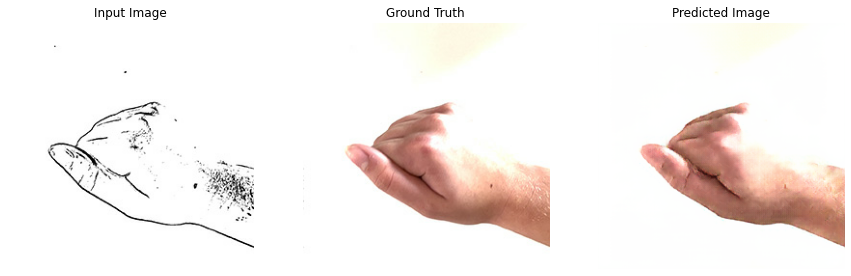

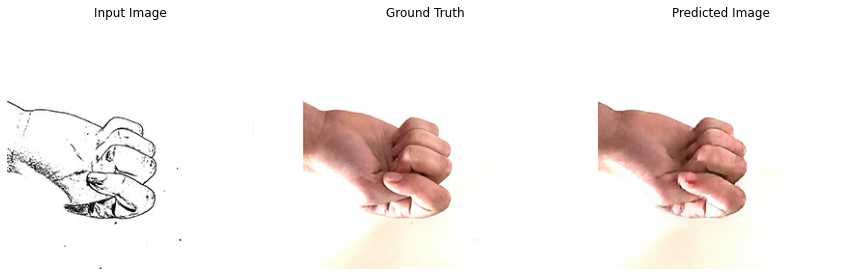

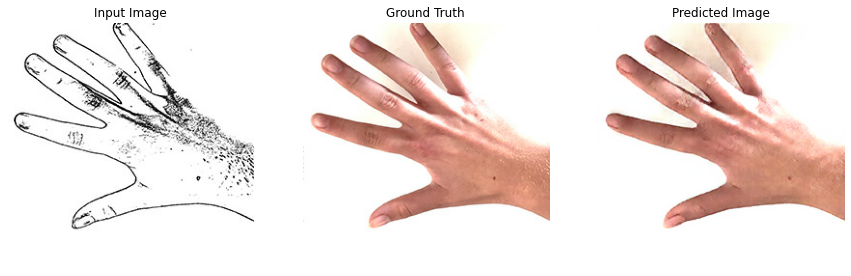

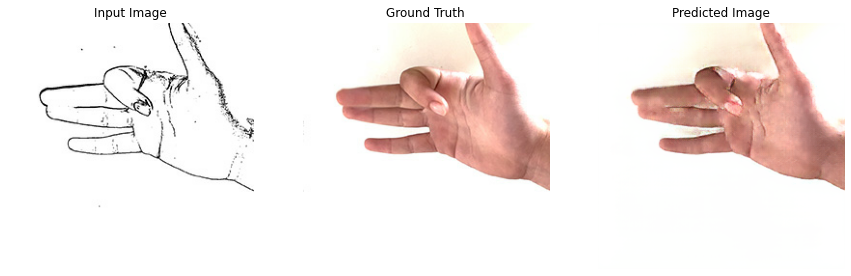

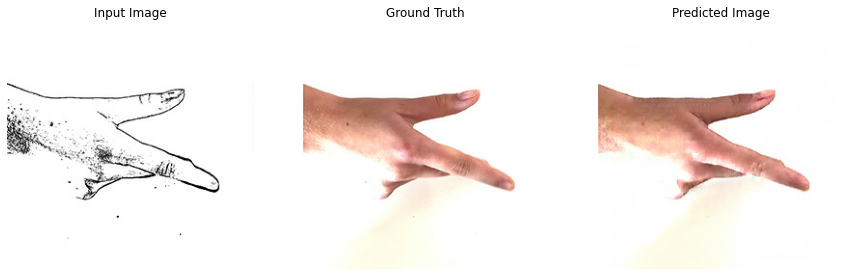

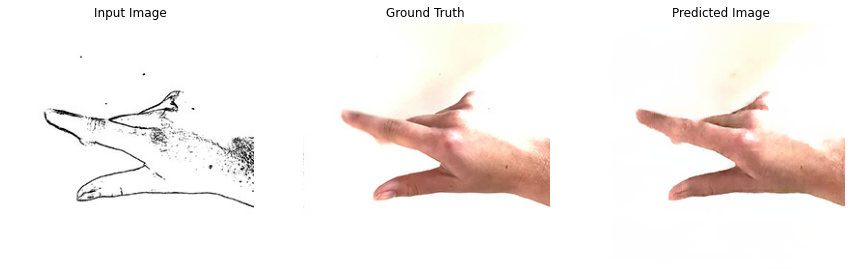

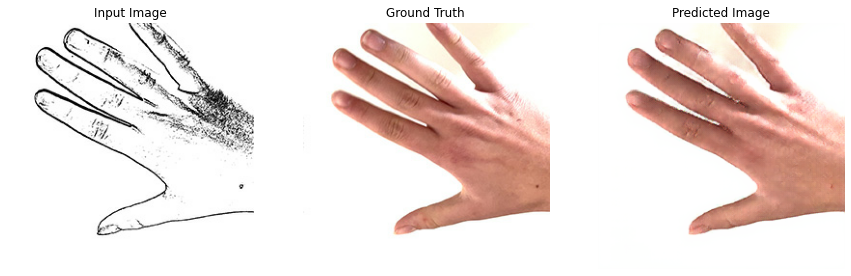

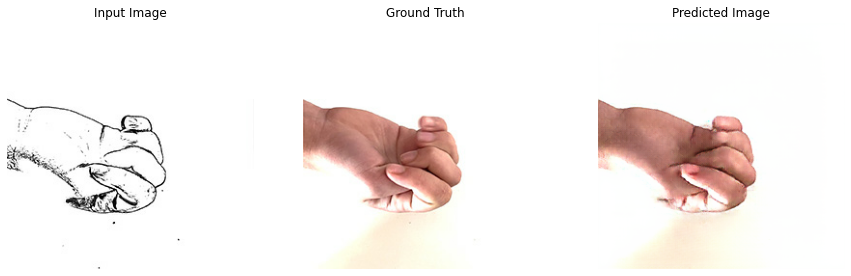

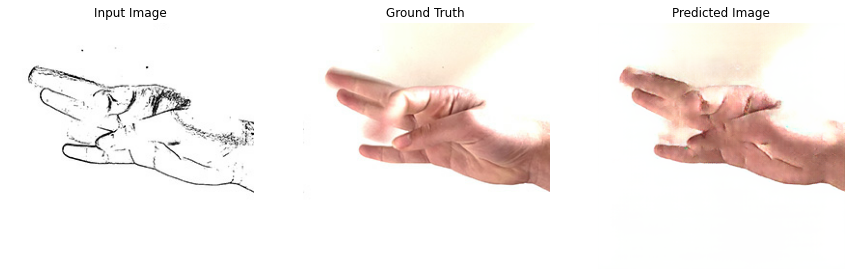

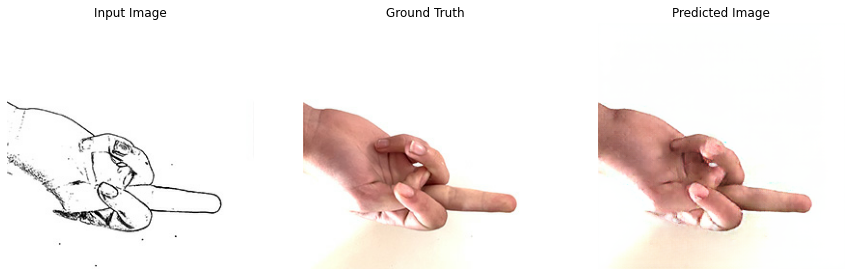

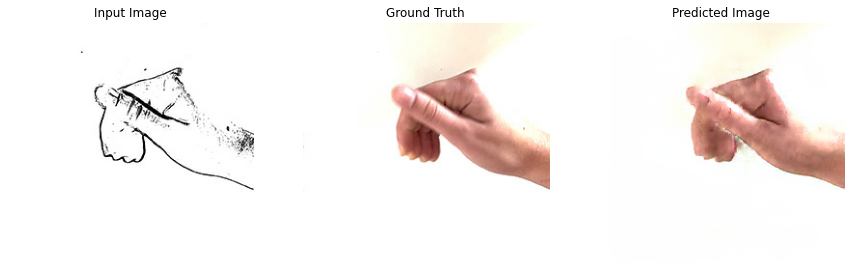

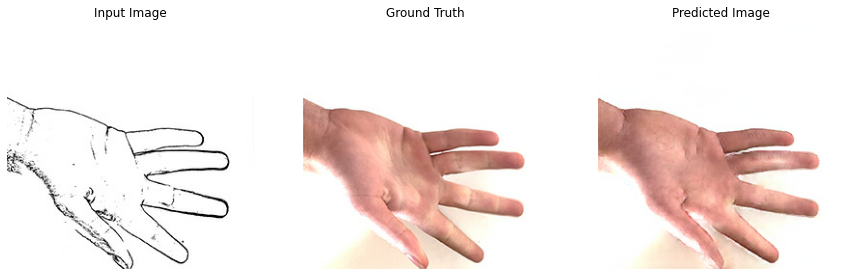

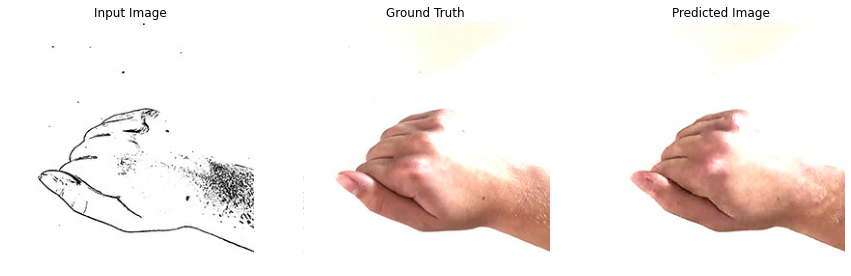

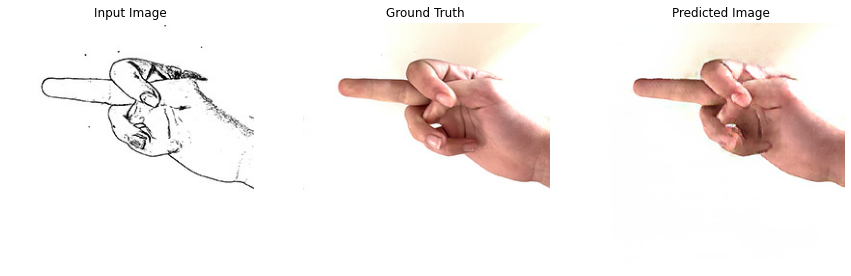

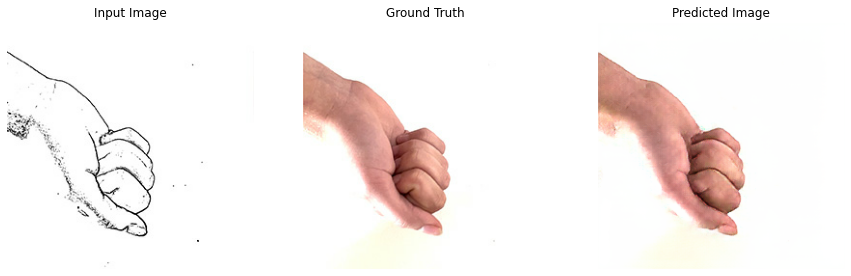

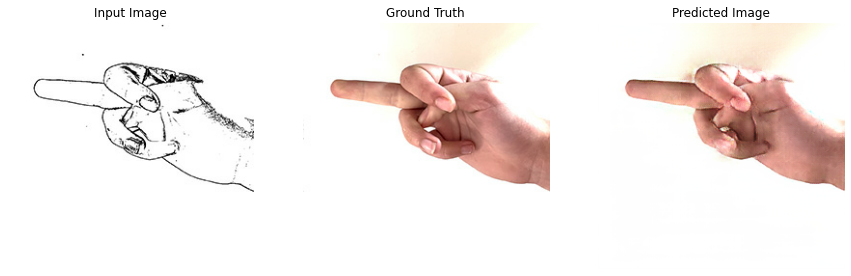

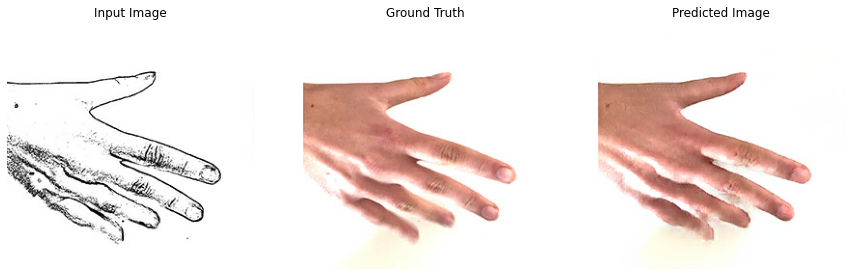

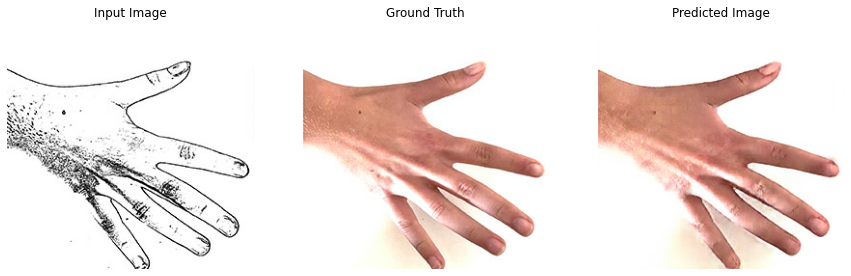

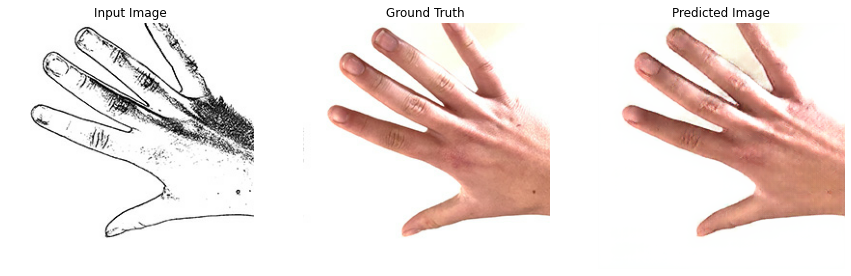

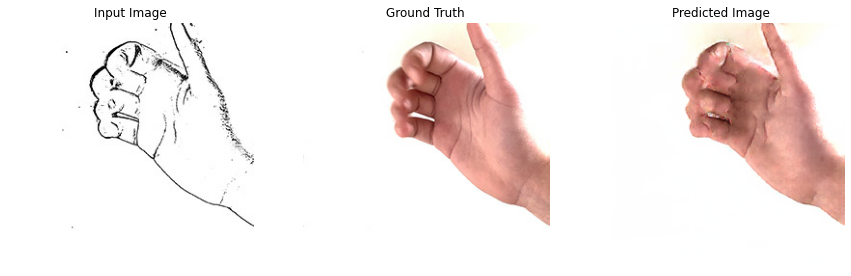

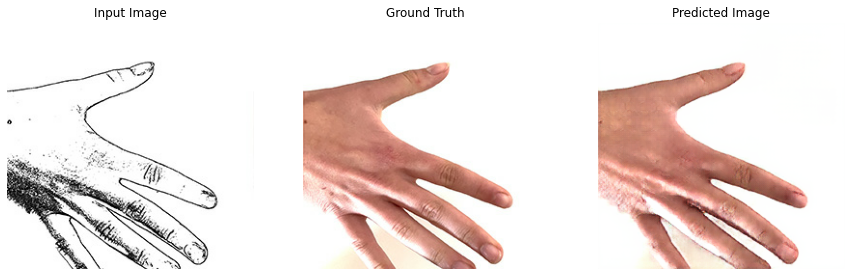

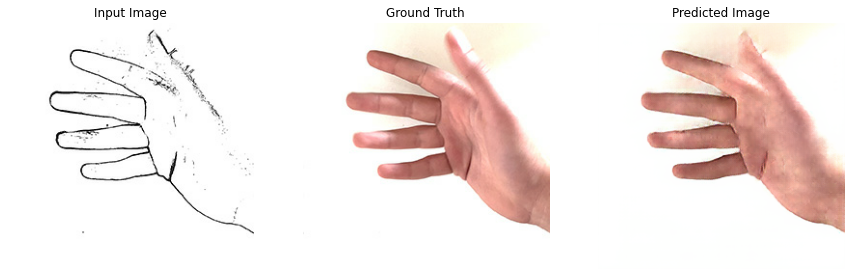

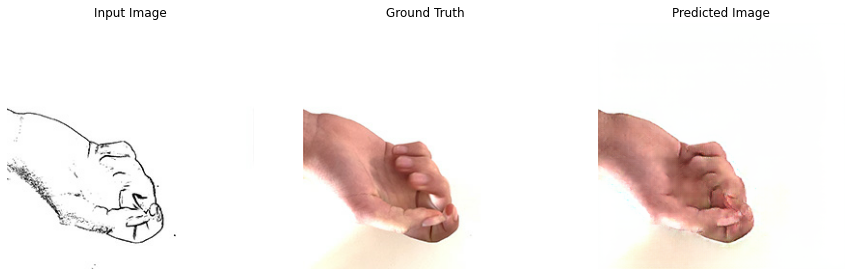

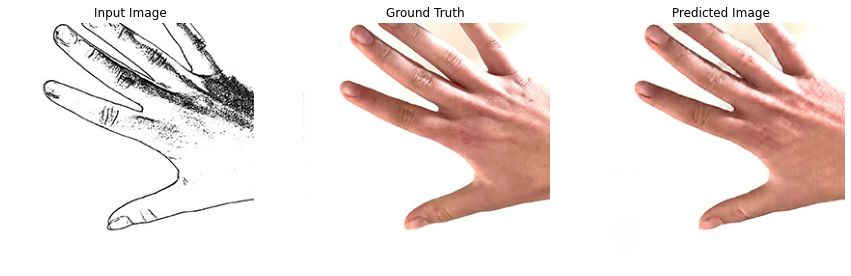

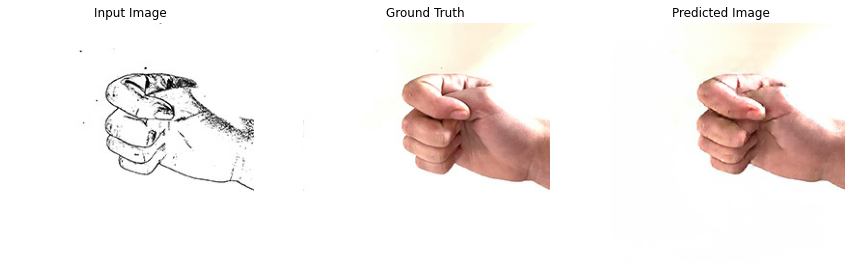

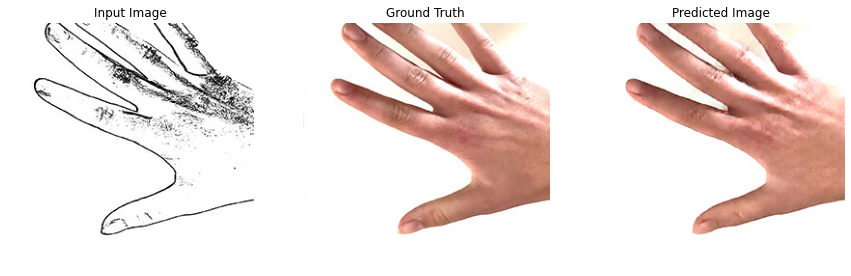

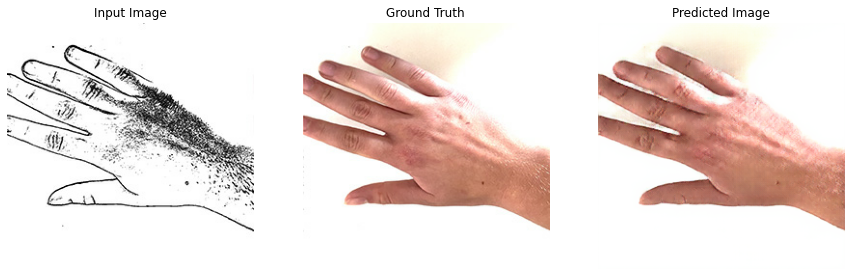

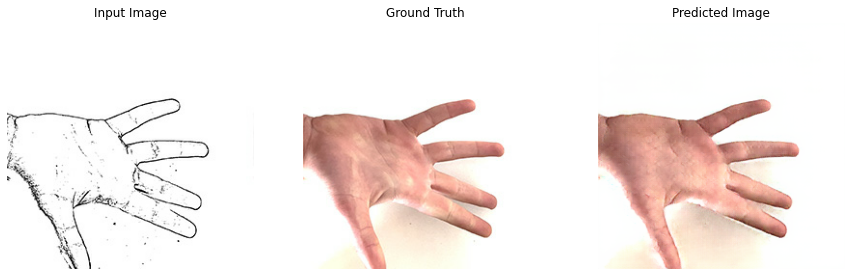

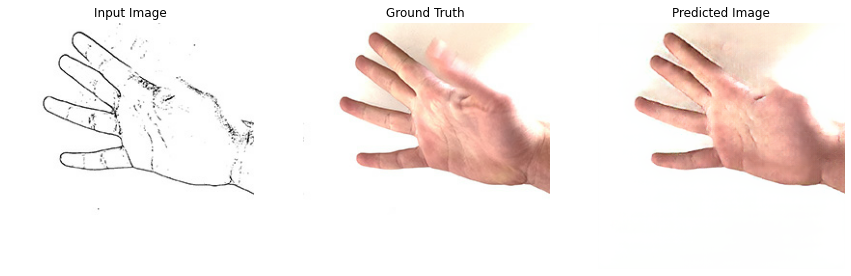

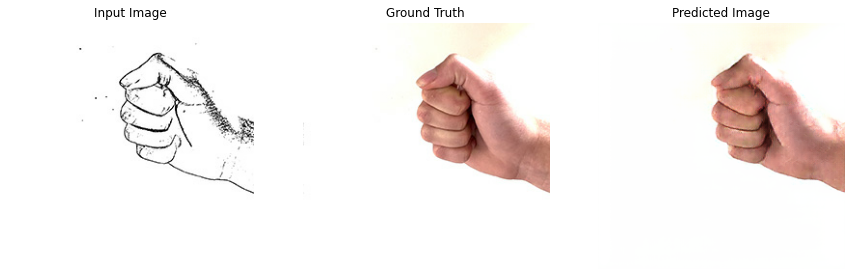

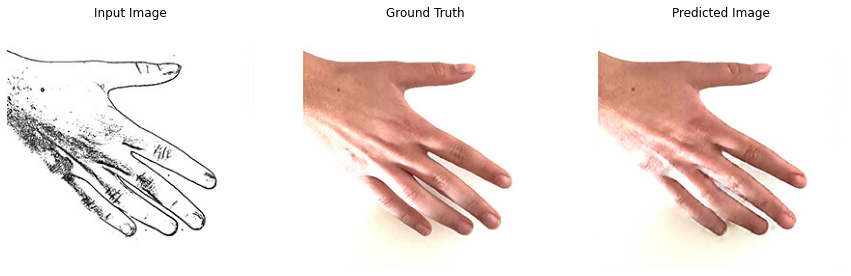

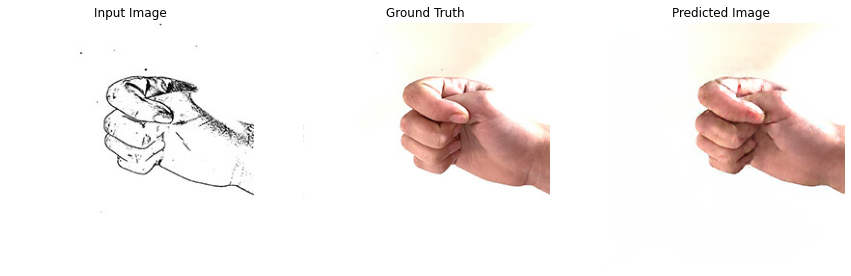

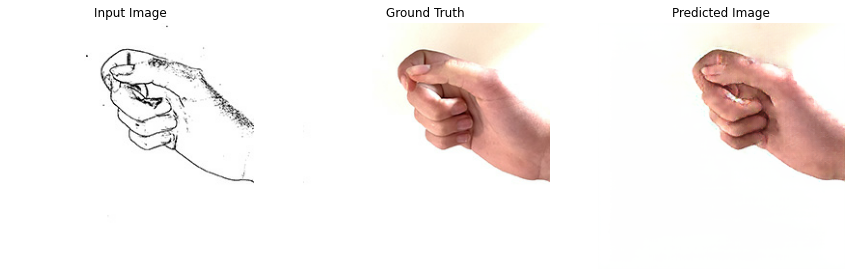

In [ ]:
# Run the trained model on the entire test dataset
for inp, tar in test_dataset:
    generate_images(generator, inp, tar)

---

# Somebody want to try using Unity to make a dynamic installation?
https://github.com/keijiro/Pix2Pix/blob/master/README.md

In [ ]:
# import argparse
import os
import tempfile
import subprocess as sp
import json
import struct
import time

import numpy as np

# modified by Doug Goodwin from:
# https://github.com/affinelayer/pix2pix-tensorflow/blob/master/server/tools/export-checkpoint.py

# SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
SCRIPT_DIR = "/content"
output_file = "pickone.pict"


def log_quantize(data, mu, bins):
    # mu-law encoding
    scale = np.max(np.abs(data))
    norm_data = data / scale
    log_data = np.sign(data) * np.log(1 + mu * np.abs(norm_data)) / np.log(1 + mu)

    _counts, edges = np.histogram(log_data, bins=bins)
    log_points = (edges[:-1] + edges[1:]) / 2
    return np.sign(log_points) * (1 / mu) * ((1 + mu)**np.abs(log_points) - 1) * scale


# parser = argparse.ArgumentParser()
# parser.add_argument("--checkpoint", required=True, help="directory with checkpoint to resume training from or use for testing")
# parser.add_argument("--output_file", required=True, help="where to write output")
# args = parser.parse_args()

model_path = None
with open(os.path.join(checkpoint_dir, "checkpoint")) as f:
    for line in f:
        line = line.strip()
        if line == "":
            continue
        key, _sep, val = line.partition(": ")
        val = val[1:-1]  # remove quotes
        if key == "model_checkpoint_path":
            model_path = val

if model_path is None:
    raise Exception("failed to find model path")

checkpoint_file = os.path.join(checkpoint_dir, model_path)
with tempfile.TemporaryDirectory() as tmp_dir:
    cmd = ["python", "-u", os.path.join(SCRIPT_DIR, "dump_checkpoints/dump_checkpoint_vars.py"), 
           "--model_type", "tensorflow", "--output_dir", tmp_dir, "--checkpoint_file", checkpoint_file]
    sp.check_call(cmd)

    with open(os.path.join(tmp_dir, "manifest.json")) as f:
        manifest = json.loads(f.read())

    names = []
    for key in manifest.keys():
        if not key.startswith("generator") or "Adam" in key or "_loss" in key or "_train" in key or "_moving_" in key:
            continue
        names.append(key)
    names = sorted(names)

    arrays = []
    for name in names:
        value = manifest[name]
        with open(os.path.join(tmp_dir, value["filename"]), "rb") as f:
            arr = np.frombuffer(f.read(), dtype=np.float32).copy().reshape(value["shape"])
            arrays.append(arr)

shapes = []
for name, arr in zip(names, arrays):
    shapes.append(dict(
        name=name,
        shape=arr.shape,
    ))

flat = np.hstack([arr.reshape(-1) for arr in arrays])

start = time.time()
index = log_quantize(flat, mu=255, bins=256).astype(np.float32)
print("index found in %0.2fs" % (time.time() - start))

print("quantizing")
encoded = np.zeros(flat.shape, dtype=np.uint8)
elem_count = 0
for i, x in enumerate(flat):
    distances = np.abs(index - x)
    nearest = np.argmin(distances)
    encoded[i] = nearest
    elem_count += 1
    if elem_count % 1000000 == 0:
        print("rate", int(elem_count / (time.time() - start)))

with open(output_file, "wb") as f:
    def write(name, buf):
        print("%s bytes %d" % (name, len(buf)))
        f.write(struct.pack(">L", len(buf)))
        f.write(buf)

    write("shape", json.dumps(shapes).encode("utf8"))
    write("index", index.tobytes())
    write("encoded", encoded.tobytes())



CalledProcessError: ignored